## embedding **ICPAC** [*Precipitation*] FORECASTING into **STORM**

load some libraries...

In [25]:
import gc
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

define some constants

In [18]:
sdic = {'JF': [1, 2], 'MAM': [3, 4, 5], 'JJAS': [6, 7, 8, 9], 'OND': [10, 11, 12]}

seas = 'MAM'
nsim = 2
nrun = 5

outp = '/home/cuwalid/SETS/sims/'
outp = '/home/cuwalid/training/forecast/regional/dataset/pre/pools/'
fdir = './forecast/'
Path(fdir).mkdir(parents=True, exist_ok=True)

fetch the data

In [11]:
# fetch the pools
pool = list(map(lambda x: sorted(glob.glob(f'{outp}/{x}/*_MAM.nc')),
                ['poolA', 'poolN', 'poolB']))
# create the combinations
allp = np.asarray([f'{x}+{y}+{z}' for x in pool[0] for
                   y in pool[1] for z in pool[2]])
# selected random combinations
what = np.random.default_rng().choice(allp, size=nsim, replace=False).tolist()

# read the ICPAC terciles
icpac = xr.open_dataset('./ICPAC_precipForecast_2022-MAM.nc', chunks='auto',
    decode_cf=True, mask_and_scale=True,)# drop_variables=['spatial_ref'],)
icpac = (icpac.tercile / 100).compute()

what are the combos?

In [13]:
print(np.asarray(what))

['/home/manuel/SETS/sims//poolA/2015_MAM.nc+/home/manuel/SETS/sims//poolN/2005_MAM.nc+/home/manuel/SETS/sims//poolB/2024_MAM.nc'
 '/home/manuel/SETS/sims//poolA/2014_MAM.nc+/home/manuel/SETS/sims//poolN/2004_MAM.nc+/home/manuel/SETS/sims//poolB/2021_MAM.nc'
 '/home/manuel/SETS/sims//poolA/2012_MAM.nc+/home/manuel/SETS/sims//poolN/2012_MAM.nc+/home/manuel/SETS/sims//poolB/2020_MAM.nc']


helper functions...

In [14]:
# sample either 0, 1, or 2 given some PROBS (probabilities)
def samp_ter(probs):
    prabs = np.random.default_rng().choice(
        [0, 1, 2], size=1, replace=True, p=probs, axis=0, shuffle=False,)
    return prabs[0]

# retrieve the pool-file given 0, 1, or 2
def CH_OLL(above, normal, below, map_ter, n_files):
    cual = [above, normal, below][map_ter]
    return cual

main function:

In [20]:
def fore_cast(chain, yy, ii):
    print(f'\ncombo: {chain}\n')
    filo = chain.split('+')
    fool = list(map(lambda x: xr.open_dataset(x, chunks='auto',
        decode_cf=True, mask_and_scale=True,), filo))

    suma = fool[1].precipitation.load().copy(deep=True)
    suma[:] = 0.0
    suma = suma.drop_vars('time')

    for i in range(nrun):
        print(f'iter.. {i+1}')
        some_a = xr.apply_ufunc(
            samp_ter, icpac,
            dask='allowed', vectorize=True,
            input_core_dims=[['p'],],
            output_core_dims=[[],],
            )
        some_b = xr.apply_ufunc(
            CH_OLL,
            fool[0].precipitation, fool[1].precipitation, fool[2].precipitation, some_a,
            kwargs={'n_files': 3.14},
            dask_gufunc_kwargs={'allow_rechunk':True, 'output_sizes':{'time':2208}},
            output_dtypes=['f4'],
            dask='parallelized', vectorize=True,
            input_core_dims=[['time'], ['time'], ['time'], [],],
            exclude_dims=set(['time',]),
            output_core_dims=[['time',]],
            )
        step = some_b.compute()
        # weighted sum
        suma = suma + step / nrun

    # data for netcdf
    stamp = pd.date_range(
        start=f'{sdic[seas][0]}/1/{yy}', end=f'{sdic[seas][-1] + 1}/1/{yy}',
        freq='1h', inclusive='left'
        )
    suma['time'] = stamp
    suma = suma.to_dataset(name='precipitation')
    suma.rio.write_crs('EPSG:4326', inplace=True)

# homogenize names
    suma.precipitation.attrs['long_name'] = 'precipitation_forecasting'
    suma.precipitation.attrs['units'] = 'mm/h'
    suma.lat.attrs['long_name'] = 'latitude'
    suma.lat.attrs['valid_min'] = -90.0
    suma.lat.attrs['valid_max'] = 90.0
    suma.lat.attrs['bounds'] = 'lat_bnds'
    suma.lon.attrs['long_name'] = 'longitude'
    suma.lon.attrs['valid_min'] = -180.0
    suma.lon.attrs['valid_max'] = 180.0
    suma.lon.attrs['bounds'] = 'lon_bnds'
    suma.time.attrs['standard_name'] = 'time'
# set.up PRECIPITATION
    suma.precipitation.encoding['dtype'] = 'f4'
    suma.precipitation.encoding['zlib'] = True
    suma.precipitation.encoding['complevel'] = 9
    suma.precipitation.encoding['contiguous'] = False
    suma.precipitation.encoding['least_significant_digit'] = 2
    suma.precipitation.encoding['shuffle'] = True
    suma.precipitation.encoding['blosc'] = True
# export to NC
    namo = f'{fdir}/{yy}_{seas}_{ii}.nc'
    print('\nXporting NC.file...')
    suma.to_netcdf(namo, mode='w')
    gc.collect()

run the precipitation forecast!

In [21]:
year = 2024 + np.r_[0:len(what)]
list(map(fore_cast, what, year, range(len(what)) ))


combo: /home/manuel/SETS/sims//poolA/2015_MAM.nc+/home/manuel/SETS/sims//poolN/2005_MAM.nc+/home/manuel/SETS/sims//poolB/2024_MAM.nc

iter.. 1
iter.. 2
iter.. 3
iter.. 4
iter.. 5
iter.. 6
iter.. 7

combo: /home/manuel/SETS/sims//poolA/2014_MAM.nc+/home/manuel/SETS/sims//poolN/2004_MAM.nc+/home/manuel/SETS/sims//poolB/2021_MAM.nc

iter.. 1
iter.. 2
iter.. 3
iter.. 4
iter.. 5
iter.. 6
iter.. 7

combo: /home/manuel/SETS/sims//poolA/2012_MAM.nc+/home/manuel/SETS/sims//poolN/2012_MAM.nc+/home/manuel/SETS/sims//poolB/2020_MAM.nc

iter.. 1
iter.. 2
iter.. 3
iter.. 4
iter.. 5
iter.. 6
iter.. 7


[None, None, None]

let's check the forecast now

In [23]:
# pick one of the outputs that were produced in "./forecast"
fc = xr.open_dataset(f'{fdir}/{"2024_MAM_0.nc"}', chunks='auto',
                     decode_cf=True, mask_and_scale=True,)
print(fc)
fcs = fc.precipitation.sum(dim=('time')).compute()

<xarray.Dataset>
Dimensions:        (lat: 225, lon: 240, time: 2208)
Coordinates:
  * lat            (lat) float32 -6.95 -6.85 -6.75 -6.65 ... 15.25 15.35 15.45
  * lon            (lon) float32 28.05 28.15 28.25 28.35 ... 51.75 51.85 51.95
  * time           (time) datetime64[ns] 2024-03-01 ... 2024-05-31T23:00:00
Data variables:
    precipitation  (time, lat, lon) float32 dask.array<chunksize=(1451, 147, 157), meta=np.ndarray>
    spatial_ref    int64 ...


the plotting happens here!

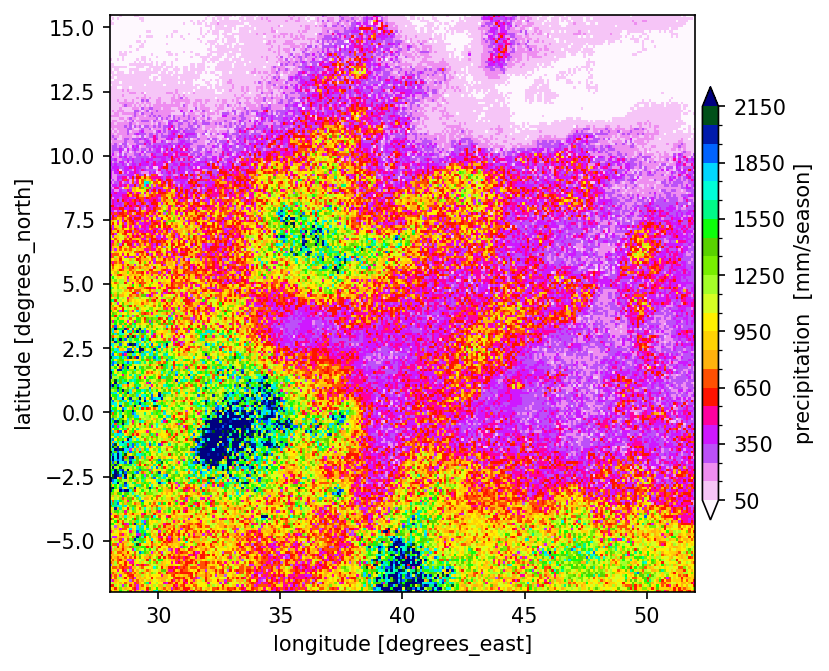

In [27]:
# plot
fig, ax = plt.subplots(figsize=(6, 5), dpi=150)
fcs.plot(
    x='lon', y='lat', cmap='gist_ncar_r', add_colorbar=True, vmin=50, vmax=2150,
    levels=22, robust=True,# ax=ax,
    cbar_kwargs={'shrink':0.75,
        'aspect':27, 'label':'precipitation  [mm/season]', 'pad':+.01,})
plt.show()
#plt.savefig(f'myFig.png', bbox_inches='tight', pad_inches=0.02)